In [30]:
import sys

import pandas as pd
import numpy as np
df = pd.read_excel("Data/S1%20File.xlsx")
#Rimozione colonne inutili e valori nulli
df.drop(columns=["Average weekday", "Average weekend day"], inplace=True)
df.dropna(inplace=True)

#Lista ordine delle colonne
columns_order = df.columns

#Cambio del valore in Genere 1:Maschio 0:Femmina
df["Gender"] = np.where(df["Gender"] == 2, 1,0)

#Normalizzazione
gender = df["Gender"]
id_no = df["ID No"]
df.drop(columns=["Gender", "ID No"], inplace=True)

df = (df - df.mean())/df.std()
df["Gender"] = gender
#df["ID No"] = id_no

#df = df[columns_order]
df.reset_index(drop=True, inplace=True)

In [31]:
from random import sample, seed
#random forest per livello ansia, senza depressione.
y_depression = df["Total Depression score"]
df_smaller = df.drop(columns=["Total anxiety score", "Total Depression score"], inplace = False)

seed(33)

test_idx_depression = sample(range(0,df_smaller.shape[0]),20)
test_depression = df_smaller.iloc[test_idx_depression]
df_training_validation = df_smaller.drop(df_smaller.index[test_idx_depression], inplace=False)

#y_depression.iloc[training_idx_depression]
#training_depression
#validation_depression
#test_depression

6.500829148963563
7.224403695430206
7.963625529588629
7.254972346941506
6.745295761280741
5.997315023613198
5.884916795524631
7.048396752405879
6.036161439114393
6.254433573618935
7.296574242735964
7.130461573441352
7.605249536443932
6.473718698170796
6.6273177758772315


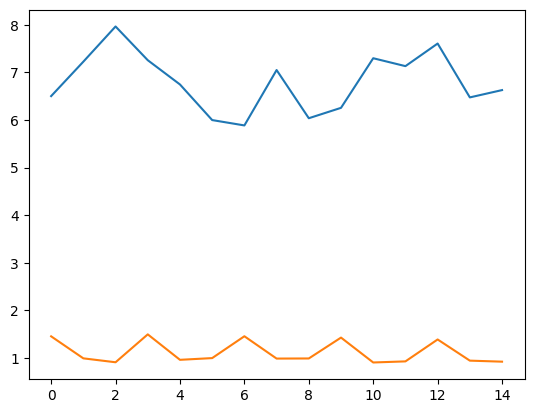

In [36]:
#crea la random forest per la depressione
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
#TODO fare il validation per parametri B ed MTRY, questa è solo una prova...
min_validation_error = sys.maxsize
min_model = None
#TODO aggiunti parametri list e max_depth, però stranamente la curva di validation error non è quella che ci si aspetta...
list_n_trees = [50,100,200,400,1000]
max_depth = [3,6,9]
MSE_VAL_list = []
MSE_TRAIN_list = []
kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(df_training_validation)
rf = None
for i in range(0, len(list_n_trees)):
        for j in range(0, len(max_depth)):
                MSE_TR = 0
                MSE_VAL = 0
                for z, (train_index, test_index) in enumerate(kf.split(df_training_validation)):
                        #TODO inserire poi i parametri. Per ora risultati anomali nel MSE
                        rf = RandomForestRegressor(n_estimators=list_n_trees[i], max_depth=max_depth[j], random_state=0)
                        rf.fit(df_training_validation.iloc[train_index], y_depression.iloc[train_index])
                        y_depression_validation = rf.predict(df_training_validation.iloc[test_index])
                        y_depression_training = rf.predict(df_training_validation.iloc[train_index])
                        #calcolo training error
                        MSE_TR = MSE_TR + np.mean((y_depression.iloc[train_index]-y_depression_training)**2)
                        #Calcolo del validation error...
                        MSE_VAL = MSE_VAL + np.mean((y_depression.iloc[test_index]-y_depression_validation)**2)
                        #print(MSE_VAL)
                if min_validation_error > MSE_VAL:
                        min_model = rf
                        min_validation_error = MSE_VAL
                MSE_VAL_list.append(MSE_VAL)
                MSE_TRAIN_list.append(MSE_TR)
                print(MSE_VAL)

plt.plot(range(0,15),MSE_VAL_list)
plt.plot(range(0,15),MSE_TRAIN_list)
plt.show()

In [37]:
#Fit the final model using training+validation set
rf.fit(df_training_validation, y_depression.iloc[df_training_validation.index])
y_depression_estimate = rf.predict(test_depression)
MSE_ERROR = np.mean((y_depression_estimate-y_depression.iloc[test_idx_depression])**2)
MSE_ERROR

0.49034488451856256

In [ ]:
from sklearn.ensemble import RandomForestRegressor 
from random import sample, seed
#random forest per livello depressione, senza ansia.
y_anxiety = df["Total anxiety score"]
df_anxiety = df.drop(columns=["Total anxiety score", "Total Depression score"], inplace = False)

seed(333)
#TODO riprendere il test set precedente


